# Long-Horizon Forecasting with NHITS


Long-horizon forecasting is challenging because of the *volatility* of the predictions and the *computational complexity*. To solve this problem we created the [NHITS](https://arxiv.org/abs/2201.12886) model and made the code available [NeuralForecast library](https://nixtla.github.io/neuralforecast/models.nhits.html). `NHITS` specializes its partial outputs in the different frequencies of the time series through hierarchical interpolation and multi-rate input
processing. 

In this notebook we show how to use `NHITS` on the [ETTm2](https://github.com/zhouhaoyi/ETDataset) benchmark dataset. This data set includes data points for 2 Electricity Transformers at 2 stations, including load, oil temperature.

We will show you how to load data, train, and perform automatic hyperparameter tuning, **to achieve SoTA performance**, outperforming even the latest Transformer architectures for a fraction of their computational cost (50x faster).

You can run these experiments using GPU with Google Colab.

<a href="https://colab.research.google.com/github/Nixtla/neuralforecast/blob/main/nbs/examples/LongHorizon_with_NHITS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Installing NeuralForecast

In [ ]:
%%capture
!pip install neuralforecast datasetsforecast

## 2. Load ETTm2 Data

The `LongHorizon` class will automatically download the complete ETTm2 dataset and process it.

It return three Dataframes: `Y_df` contains the values for the target variables, `X_df` contains exogenous calendar features and `S_df` contains static features for each time-series (none for ETTm2). For this example we will only use `Y_df`.

If you want to use your own data just replace `Y_df`. Be sure to use a long format and have a simmilar structure than our data set.

In [ ]:
import pandas as pd
from datasetsforecast.long_horizon import LongHorizon

# Change this to your own data to try the model
Y_df, _, _ = LongHorizon.load(directory='./', group='ETTm2')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

# For this excercise we are going to take 20% of the DataSet
n_time = len(Y_df.ds.unique())
val_size = int(.2 * n_time)
test_size = int(.2 * n_time)

Y_df.groupby('unique_id').head(2)

,unique_id,ds,y
0,HUFL,2016-07-01 00:00:00,-0.041413
1,HUFL,2016-07-01 00:15:00,-0.185467
57600,HULL,2016-07-01 00:00:00,0.040104
57601,HULL,2016-07-01 00:15:00,-0.214450
115200,LUFL,2016-07-01 00:00:00,0.695804
115201,LUFL,2016-07-01 00:15:00,0.434685
172800,LULL,2016-07-01 00:00:00,0.434430
172801,LULL,2016-07-01 00:15:00,0.428168
230400,MUFL,2016-07-01 00:00:00,-0.599211
230401,MUFL,2016-07-01 00:15:00,-0.658068


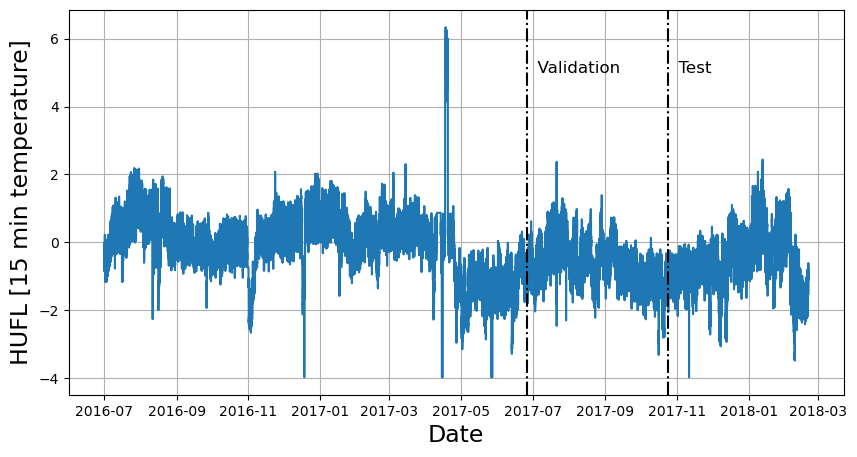

In [ ]:
import matplotlib.pyplot as plt

# We are going to plot the temperature of the transformer 
# and marking the validation and train splits
u_id = 'HUFL'
x_plot = pd.to_datetime(Y_df[Y_df.unique_id==u_id].ds)
y_plot = Y_df[Y_df.unique_id==u_id].y.values

x_val = x_plot[n_time - val_size - test_size]
x_test = x_plot[n_time - test_size]

fig = plt.figure(figsize=(10, 5))
fig.tight_layout()

plt.plot(x_plot, y_plot)
plt.xlabel('Date', fontsize=17)
plt.ylabel('HUFL [15 min temperature]', fontsize=17)

plt.axvline(x_val, color='black', linestyle='-.')
plt.axvline(x_test, color='black', linestyle='-.')
plt.text(x_val, 5, '  Validation', fontsize=12)
plt.text(x_test, 5, '  Test', fontsize=12)

plt.grid()

## 3. Hyperparameter selection and forecasting

The `AutoNHITS` class will automatically perform hyperparamter tunning using [Tune library](https://docs.ray.io/en/latest/tune/index.html), exploring a user-defined or default search space. Models are selected based on the error on a validation set and the best model is then stored and used during inference. 

The `AutoNHITS.default_config` attribute contains a suggested hyperparameter space. Here, we specify a different search space following the paper's hyperparameters. Notice that *1000 Stochastic Gradient Steps* are enough to achieve SoTA performance. Feel free to play around with this space.

In [ ]:
from ray import tune
from neuralforecast.auto import AutoNHITS
from neuralforecast.core import NeuralForecast

In [ ]:
horizon = 96 # 24hrs = 4 * 15 min.

# Use your own config or AutoNHITS.default_config
nhits_config = {
       "learning_rate": tune.choice([1e-3]),                                     # Initial Learning rate
       "max_steps": tune.choice([1000]),                                         # Number of SGD steps
       "input_size": tune.choice([5 * horizon]),                                 # input_size = multiplier * horizon
       "batch_size": tune.choice([7]),                                           # Number of series in windows
       "windows_batch_size": tune.choice([256]),                                 # Number of windows in batch
       "n_pool_kernel_size": tune.choice([[2, 2, 2], [16, 8, 1]]),               # MaxPool's Kernelsize
       "n_freq_downsample": tune.choice([[168, 24, 1], [24, 12, 1], [1, 1, 1]]), # Interpolation expressivity ratios
       "activation": tune.choice(['ReLU']),                                      # Type of non-linear activation
       "n_blocks":  tune.choice([[1, 1, 1]]),                                    # Blocks per each 3 stacks
       "mlp_units":  tune.choice([[[512, 512], [512, 512], [512, 512]]]),        # 2 512-Layers per block for each stack
       "interpolation_mode": tune.choice(['linear']),                            # Type of multi-step interpolation
       "val_check_steps": tune.choice([100]),                                    # Compute validation every 100 epochs
       "random_seed": tune.randint(1, 10),
    }

:::{.callout-tip}
Refer to https://docs.ray.io/en/latest/tune/index.html for more information on the different space options, such as lists and continous intervals.m
:::

To instantiate `AutoNHITS` you need to define:

* `h`: forecasting horizon
* `loss`: training loss. Use the `DistributionLoss` to produce probabilistic forecasts.
* `config`: hyperparameter search space. If `None`, the `AutoNHITS` class will use a pre-defined suggested hyperparameter space.
* `num_samples`: number of configurations explored.

In [ ]:
models = [AutoNHITS(h=horizon,
                    config=nhits_config, 
                    num_samples=5)]

Fit the model by instantiating a `NeuralForecast` object with the following required parameters:

* `models`: a list of models.

* `freq`: a string indicating the frequency of the data. (See [panda's available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).)

The `cross_validation` method allows you to simulate multiple historic forecasts, greatly simplifying pipelines by replacing for loops with `fit` and `predict` methods.

With time series data, cross validation is done by defining a sliding window across the historical data and predicting the period following it. This form of cross validation allows us to arrive at a better estimation of our model’s predictive abilities across a wider range of temporal instances while also keeping the data in the training set contiguous as is required by our models.

The `cross_validation` method will use the validation set for hyperparameter selection, and will then produce the forecasts for the test set.

In [ ]:
%%capture
nf = NeuralForecast(
    models=models,
    freq='15min')

Y_hat_df = nf.cross_validation(df=Y_df, val_size=val_size,
                               test_size=test_size, n_windows=None)

## 4. Evaluate Results

The `AutoNHITS` class contains a `results` tune attribute that stores information of each configuration explored. It contains the validation loss and best validation hyperparameter.

In [ ]:
nf.models[0].results.get_best_result().config

{'learning_rate': 0.001,
 'max_steps': 1000,
 'input_size': 480,
 'batch_size': 7,
 'windows_batch_size': 256,
 'n_pool_kernel_size': [2, 2, 2],
 'n_freq_downsample': [24, 12, 1],
 'activation': 'ReLU',
 'n_blocks': [1, 1, 1],
 'mlp_units': [[512, 512], [512, 512], [512, 512]],
 'interpolation_mode': 'linear',
 'val_check_steps': 100,
 'random_seed': 8,
 'h': 96,
 'loss': MAE(),
 'valid_loss': MAE()}

In [ ]:
y_true = Y_hat_df.y.values
y_hat = Y_hat_df['AutoNHITS'].values

n_series = len(Y_df.unique_id.unique())

y_true = y_true.reshape(n_series, -1, horizon)
y_hat = y_hat.reshape(n_series, -1, horizon)

print('Parsed results')
print('2. y_true.shape (n_series, n_windows, n_time_out):\t', y_true.shape)
print('2. y_hat.shape  (n_series, n_windows, n_time_out):\t', y_hat.shape)

Parsed results
2. y_true.shape (n_series, n_windows, n_time_out):	 (7, 11425, 96)
2. y_hat.shape  (n_series, n_windows, n_time_out):	 (7, 11425, 96)


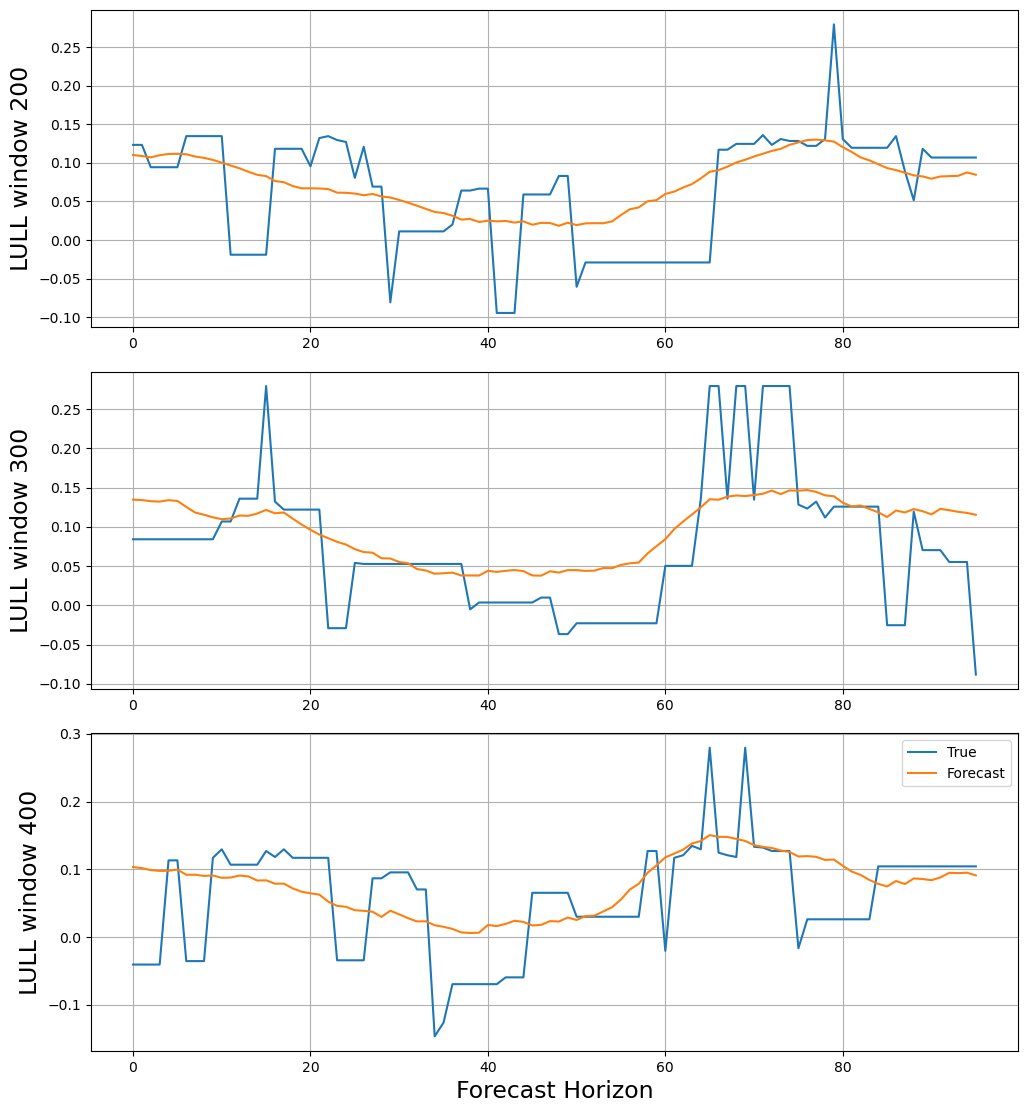

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 11))
fig.tight_layout()

series = ['HUFL','HULL','LUFL','LULL','MUFL','MULL','OT']
series_idx = 3

for idx, w_idx in enumerate([200, 300, 400]):
  axs[idx].plot(y_true[series_idx, w_idx,:],label='True')
  axs[idx].plot(y_hat[series_idx, w_idx,:],label='Forecast')
  axs[idx].grid()
  axs[idx].set_ylabel(series[series_idx]+f' window {w_idx}', 
                      fontsize=17)
  if idx==2:
    axs[idx].set_xlabel('Forecast Horizon', fontsize=17)
plt.legend()
plt.show()
plt.close()

Finally, we compute the test errors for the two metrics of interest:

$\qquad MAE = \frac{1}{Windows * Horizon} \sum_{\tau} |y_{\tau} - \hat{y}_{\tau}| \qquad$ and $\qquad MSE = \frac{1}{Windows * Horizon} \sum_{\tau} (y_{\tau} - \hat{y}_{\tau})^{2} \qquad$

In [ ]:
from neuralforecast.losses.numpy import mae, mse

print('MAE: ', mae(y_hat, y_true))
print('MSE: ', mse(y_hat, y_true))

MAE:  0.24862242128243706
MSE:  0.17257850996828134


For reference we can check the performance when compared
to previous 'state-of-the-art' long-horizon Transformer-based forecasting methods from the [NHITS paper](https://arxiv.org/abs/2201.12886). To recover or improve the paper results try setting `hyperopt_max_evals=30` in [Hyperparameter Tuning](#cell-4).

Mean Absolute Error (MAE):

| Horizon   | NHITS        | AutoFormer | InFormer | ARIMA 
|---        |---           |---         |---       |---
|  96       |  **0.249**   |   0.339    |  0.453   | 0.301 
|  192      |  0.305       |   0.340    |  0.563   | 0.345 
|  336      |  0.346       |   0.372    |  0.887   | 0.386 
|  720      |  0.426       |   0.419    |  1.388   | 0.445 

Mean Squared Error (MSE):

| Horizon   | NHITS        | AutoFormer | InFormer | ARIMA 
|---        |---           |---         |---       |---
|  96       |  **0.173**   |   0.255    |  0.365   | 0.225 
|  192      |  0.245       |   0.281    |  0.533   | 0.298 
|  336      |  0.295       |   0.339    |  1.363   | 0.370 
|  720      |  0.401       |   0.422    |  3.379   | 0.478 

## References

[Cristian Challu, Kin G. Olivares, Boris N. Oreshkin, Federico Garza, Max Mergenthaler-Canseco, Artur Dubrawski (2021). NHITS: Neural Hierarchical Interpolation for Time Series Forecasting. Accepted at AAAI 2023.](https://arxiv.org/abs/2201.12886)